# 1. Uczenie klasyfikatora

Trochę informacji: https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt

In [2]:
##selected classses
classes = ["Lemon", "Raspberry", "Mandarine", "Pear 2", "Apple Red 1", "Strawberry", "Pomegranate", "Pepino", "Kaki", "Apricot", "Ginger Root", "Huckleberry"]

In [3]:
##load with rescaling so that size was OK, batch_size=1, we will create batches later, color, classes..
trdata_gen = ImageDataGenerator(rescale=1./255)
traindata = trdata_gen.flow_from_directory(directory="../data/Training",target_size=(224,224), batch_size=1,color_mode="rgb", classes=classes,class_mode="categorical") 

Found 11531 images belonging to 12 classes.


In [4]:
traindata.class_indices

{'Lemon': 0,
 'Raspberry': 1,
 'Mandarine': 2,
 'Pear 2': 3,
 'Apple Red 1': 4,
 'Strawberry': 5,
 'Pomegranate': 6,
 'Pepino': 7,
 'Kaki': 8,
 'Apricot': 9,
 'Ginger Root': 10,
 'Huckleberry': 11}

In [5]:
CLASSES = len(traindata.class_indices)

In [6]:
tsdata_gen = ImageDataGenerator(rescale=1./255)
testdata = tsdata_gen.flow_from_directory(directory="../data/Test", target_size=(224,224),batch_size=1, color_mode="rgb", classes=classes,class_mode="categorical")

Found 1981 images belonging to 12 classes.


(1, 224, 224, 3) [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


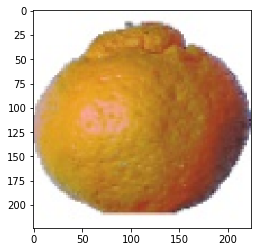

(1, 224, 224, 3) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


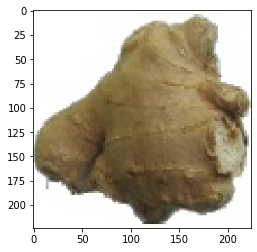

(1, 224, 224, 3) [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


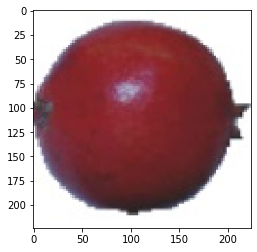

(1, 224, 224, 3) [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


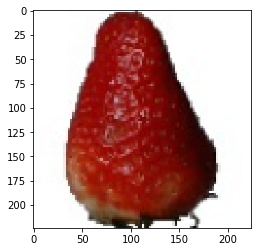

(1, 224, 224, 3) [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


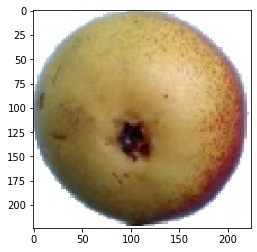

(1, 224, 224, 3) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


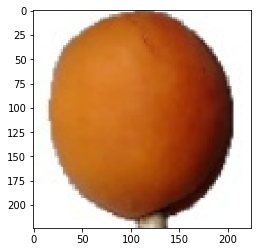

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


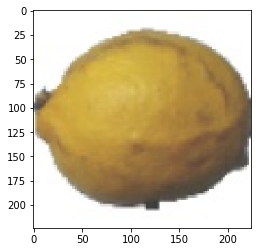

(1, 224, 224, 3) [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


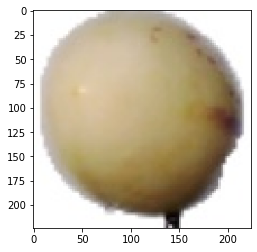

(1, 224, 224, 3) [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


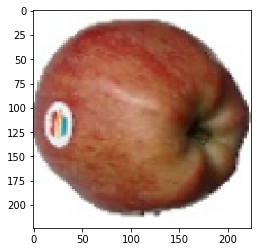

(1, 224, 224, 3) [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


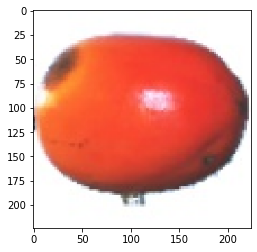

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


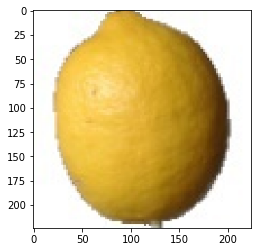

(1, 224, 224, 3) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


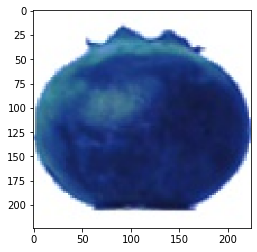

(1, 224, 224, 3) [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


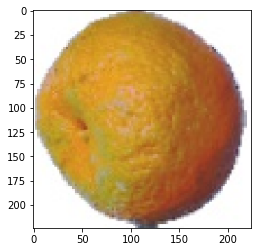

(1, 224, 224, 3) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


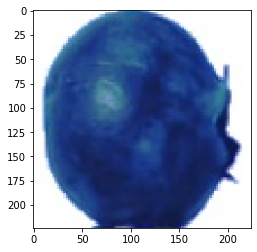

(1, 224, 224, 3) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


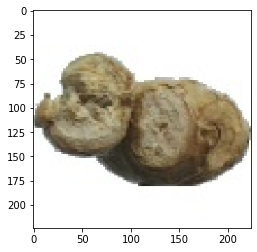

(1, 224, 224, 3) [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


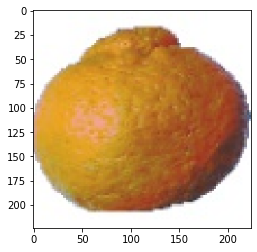

(1, 224, 224, 3) [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


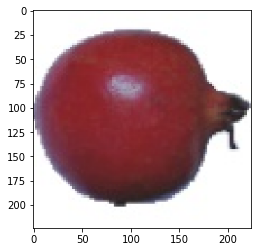

(1, 224, 224, 3) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


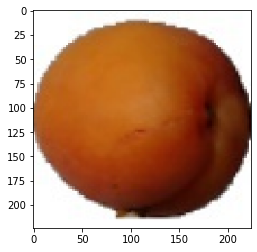

(1, 224, 224, 3) [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


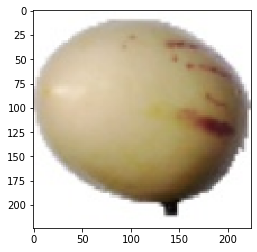

(1, 224, 224, 3) [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


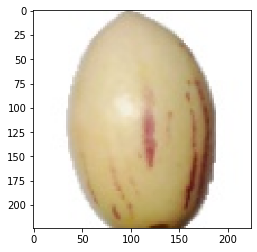

In [50]:
##display fotos
# for _ in range(20):
#     img, label = testdata.next()
#     print(img.shape, label)   #  (1,256,256,3)
#     plt.imshow(img[0])
#     plt.show()

In [8]:
## our sweet NN
base_model = VGG16(weights='imagenet', include_top = False , input_shape=(224,224, 3))
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [53]:
##TO CHECK OUT- LEAVE ONLY LAST ON
flatten= Flatten()(base_model.layers[-1].output)
# add new classifier layers
# class_dense = Dense(1024, activation='relu')(flatten) 
output = Dense(CLASSES, activation='softmax')(flatten)
# define new model
## maybe add dropout and maybe one more dense
model_pretrained = Model(inputs=base_model.inputs, outputs=output)
# summarize
model_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [54]:
##freeze all  base_model layers and train the last ones
for layer in base_model.layers:
    layer.trainable = False

In [55]:
model_pretrained.compile(optimizer='rmsprop', ##adam?
              loss='categorical_crossentropy',
              metrics=['acc'])

In [56]:
EPOCHS = 50
BATCH_SIZE = 64
STEPS_PER_EPOCH = 32
VALIDATION_STEPS = 64
MODEL_FILE = 'models/vgg16-pretrained-rmsprop.model'

In [57]:
model_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [58]:
checkpoint = ModelCheckpoint("vgg16_1_pretrained.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early_stopper = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=20, verbose=1, mode='auto')
#csv_logger = CSVLogger('./results/vgg16imagenetpretrained.csv')

In [59]:
# checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
history_pretrained = model_pretrained.fit(
    traindata,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=testdata,
    validation_steps=VALIDATION_STEPS,
    shuffle=True,
    callbacks=[checkpoint, early_stopper]
)


model.save(MODEL_FILE)

Epoch 1/50
32/32 [==============================] - 14s 412ms/step - loss: 8.0850 - acc: 0.1248 - val_loss: 3.1410 - val_acc: 0.1406

Epoch 00001: val_acc improved from -inf to 0.14062, saving model to vgg16_1_pretrained.h5
Epoch 2/50
32/32 [==============================] - 13s 414ms/step - loss: 4.5208 - acc: 0.2400 - val_loss: 4.4257 - val_acc: 0.1875

Epoch 00002: val_acc improved from 0.14062 to 0.18750, saving model to vgg16_1_pretrained.h5
Epoch 3/50
32/32 [==============================] - 13s 430ms/step - loss: 2.8004 - acc: 0.4697 - val_loss: 5.1920 - val_acc: 0.2031

Epoch 00003: val_acc improved from 0.18750 to 0.20312, saving model to vgg16_1_pretrained.h5
Epoch 4/50
32/32 [==============================] - 14s 447ms/step - loss: 2.4645 - acc: 0.5678 - val_loss: 2.4274 - val_acc: 0.3906

Epoch 00004: val_acc improved from 0.20312 to 0.39062, saving model to vgg16_1_pretrained.h5
Epoch 5/50
32/32 [==============================] - 14s 456ms/step - loss: 2.0908 - acc: 0.4177

KeyboardInterrupt: 

In [ ]:
print(history.history.keys())
plt.plot(history_pretrained.history['acc'])
plt.plot(history_pretrained.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('acc_training_process.png')
plt.show()

## 1.2 SVM

In [9]:
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
# max_pooling = MaxPool2D()()
flatten_svm= Flatten()(base_model.layers[-1].output)
# add new classifier layers

# class_dense_svm = Dense(4096, activation='relu')(base_model.layers[-1].output) ##maybe not relu...
features_svm = Model(inputs=base_model.input, outputs=flatten_svm)
features_svm.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
train_features = features_svm.predict(traindata)
test_features = features_svm.predict(testdata)

In [12]:
train_features

array([[0.01073986, 0.        , 0.        , ..., 0.        , 0.6937961 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.71982026,
        0.        ],
       [0.03550944, 0.        , 0.        , ..., 0.        , 0.84669495,
        0.        ],
       ...,
       [0.08657982, 0.        , 0.        , ..., 0.        , 0.6622927 ,
        0.        ],
       [0.09268637, 0.        , 0.        , ..., 0.        , 0.45052522,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.61840695,
        0.        ]], dtype=float32)

In [14]:
from sklearn.model_selection import train_test_split
from numpy import asarray
from numpy import save

# load numpy array from npy file
from numpy import load

In [15]:
X_train = train_features
y_train = np.array(traindata.labels)
X_test = test_features
y_test = np.array(testdata.labels)

In [25]:
y_test.shape
X_test.shape

(1981, 25088)

In [16]:
###save if the first time
save('train_data.npy', X_train)
save('train_labels.npy', y_train)
save('test_data.npy', X_test)
save('test_labels.npy', y_test)

In [7]:
X_train = load('train_data.npy')
y_train = load ('train_labels.npy')
X_test = load('test_data.npy')
y_test = load('test_labels.npy')

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=85)

In [18]:
import sklearn
from sklearn import svm

In [ ]:
svm_rbf = svm.SVC(kernel='rbf',C=100, verbose=2)
svm_rbf.fit(X_train, y_train)
y_pred_train_rbf = svm_rbf.predict(X_train)
y_pred_test_rbf = svm_rbf.predict(X_test)


In [ ]:
print(sklearn.metrics.classification_report(y_train, y_pred_train_rbf))
print(sklearn.metrics.classification_report(y_test, y_pred_test_rbf))

In [19]:
svm_linear = svm.SVC(kernel='linear',C=100, verbose=2)
svm_linear.fit(X_train, y_train)
y_pred_train_lin = svm_linear.predict(X_train)
y_pred_test_lin = svm_linear.predict(X_test)

[LibSVM]

In [20]:
print(sklearn.metrics.classification_report(y_train, y_pred_train_lin))
print(sklearn.metrics.classification_report(y_test, y_pred_test_lin))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       767
           1       1.00      1.00      1.00       769
           2       1.00      1.00      1.00       764
           3       1.00      1.00      1.00       772
           4       1.00      1.00      1.00       774
           5       1.00      1.00      1.00       754
           6       1.00      1.00      1.00       793
           7       1.00      1.00      1.00       765
           8       1.00      1.00      1.00       771
           9       1.00      1.00      1.00       750
          10       1.00      1.00      1.00       766
          11       1.00      1.00      1.00       779

    accuracy                           1.00      9224
   macro avg       1.00      1.00      1.00      9224
weighted avg       1.00      1.00      1.00      9224

              precision    recall  f1-score   support

           0       0.09      0.15      0.11       164
           1       0.07 

In [21]:
svm_poly = svm.SVC(kernel='poly',C= 100, degree=2, verbose=2)
svm_poly.fit(X_train, y_train)
y_pred_train_poly = svm_poly.predict(X_train)
y_pred_test_poly = svm_poly.predict(X_test)
print(sklearn.metrics.classification_report(y_train, y_pred_train_poly))
print(sklearn.metrics.classification_report(y_test, y_pred_test_poly))

[LibSVM]              precision    recall  f1-score   support

           0       0.83      0.85      0.84       767
           1       0.78      0.84      0.81       769
           2       0.82      0.84      0.83       764
           3       0.83      0.84      0.83       772
           4       0.82      0.84      0.83       774
           5       0.85      0.83      0.84       754
           6       0.85      0.83      0.84       793
           7       0.84      0.81      0.82       765
           8       0.86      0.83      0.84       771
           9       0.83      0.83      0.83       750
          10       0.84      0.81      0.82       766
          11       0.83      0.84      0.84       779

    accuracy                           0.83      9224
   macro avg       0.83      0.83      0.83      9224
weighted avg       0.83      0.83      0.83      9224

              precision    recall  f1-score   support

           0       0.08      0.16      0.11       164
           1    